In [4]:
!pip install kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# for basic SMILES operations, descriptors and fingerprints
!pip install -q rdkit-pypi

# for graphs
!pip install -q dgl

# for mol2vec
!pip install -q mol2vec

# for protein features
!pip install Bio
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.0 MB/s eta 0:00:00


In [6]:
#@title Imports of Required Librarys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import statistics
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm, skew

# for basic SMILES operations, descriptors and fingerprints
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys, AllChem, Draw
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.rdPartialCharges import ComputeGasteigerCharges

# for graphs
import torch

# for mol2vec
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

# for chemical language models
from transformers import AutoModel, AutoTokenizer

# for Target Protein features
from Bio.PDB import *
import re


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [7]:
import json

with open('kaggle.json', 'r') as f:
    kaggle_json = json.load(f)

import os

os.environ['KAGGLE_USERNAME'] = kaggle_json['username']
os.environ['KAGGLE_KEY'] = kaggle_json['key']

In [8]:
#@title Getting the Kaggle Dataset

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the competition data
api.competition_download_files('leash-BELKA', path='./kaggle_data')

# Unzip the downloaded file
import zipfile
with zipfile.ZipFile('./kaggle_data/leash-BELKA.zip', 'r') as zip_ref:
    zip_ref.extractall('./kaggle_data')


In [46]:
#@title Checking First 10,000,000 Entries

# Load a sample of the training data
df = pd.read_csv('./kaggle_data/train.csv', nrows=10000000)

# Separate the dataset into binding and non-binding examples
df_bind = df[df['binds'] == 1]
df_no_bind = df[df['binds'] == 0]

# Determine the number of samples to take (minimum of 500 or half of the smaller group)
n_samples = min(10000, len(df_bind), len(df_no_bind))

# Randomly sample an equal number from each group
df_bind_sample = df_bind.sample(n_samples, random_state=42)
df_no_bind_sample = df_no_bind.sample(n_samples, random_state=42)

# Combine the samples
df = pd.concat([df_bind_sample, df_no_bind_sample]).reset_index(drop=True)

# Shuffle the combined dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows and the distribution of the 'binds' column
print(df.head())
print("\nDistribution of 'binds' column:")
print(df['binds'].value_counts(normalize=True))

# Display the first few rows
df.head()

        id                            buildingblock1_smiles  \
0  8846314   C=CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  4653019    C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  8157741  C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  3565117   C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21   
4  6248316  C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

     buildingblock2_smiles      buildingblock3_smiles  \
0           CCSC1CCC1(O)CN          Cc1ccc(CN)c(Cl)n1   
1            COc1cncc(N)c1   Cl.Cl.NCc1nccn1-c1ccccc1   
2        Cl.Cn1cc(N)ccc1=O                 Cc1nnsc1CN   
3            COc1cncc(N)n1  NCc1ccc(NC(=O)c2ccco2)cc1   
4  NCc1cc(-c2ccccc2)[nH]n1      CN(C)c1ncccc1CN.Cl.Cl   

                                     molecule_smiles protein_name  binds  
0  C=CC[C@@H](Nc1nc(NCc2ccc(C)nc2Cl)nc(NCC2(O)CCC...          HSA      0  
1  C#CC[C@H](Nc1nc(NCc2nccn2-c2ccccc2)nc(Nc2cncc(...          HSA      1  
2  C=CCC[C@@H](Nc1nc(NCc2snnc2C)nc(Nc2ccc(=O)n(C)... 

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,8846314,C=CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,CCSC1CCC1(O)CN,Cc1ccc(CN)c(Cl)n1,C=CC[C@@H](Nc1nc(NCc2ccc(C)nc2Cl)nc(NCC2(O)CCC...,HSA,0
1,4653019,C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,COc1cncc(N)c1,Cl.Cl.NCc1nccn1-c1ccccc1,C#CC[C@H](Nc1nc(NCc2nccn2-c2ccccc2)nc(Nc2cncc(...,HSA,1
2,8157741,C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,Cl.Cn1cc(N)ccc1=O,Cc1nnsc1CN,C=CCC[C@@H](Nc1nc(NCc2snnc2C)nc(Nc2ccc(=O)n(C)...,BRD4,1
3,3565117,C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1cncc(N)n1,NCc1ccc(NC(=O)c2ccco2)cc1,C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCc2ccc(NC(=O)c3cc...,HSA,1
4,6248316,C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,NCc1cc(-c2ccccc2)[nH]n1,CN(C)c1ncccc1CN.Cl.Cl,C=CCC(CC=C)(Nc1nc(NCc2cc(-c3ccccc3)[nH]n2)nc(N...,BRD4,0


In [47]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     20000 non-null  int64 
 1   buildingblock1_smiles  20000 non-null  object
 2   buildingblock2_smiles  20000 non-null  object
 3   buildingblock3_smiles  20000 non-null  object
 4   molecule_smiles        20000 non-null  object
 5   protein_name           20000 non-null  object
 6   binds                  20000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.1+ MB
None


In [48]:
#@title Getting All Unique Joint Molecules

# assign unique molecule_smiles values to variable. This is all we need for the purpose of this demo
smiles = df['molecule_smiles'].unique()
print(len(smiles))

19661


In [49]:
# obtain RDKit mol objects from SMILES
mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

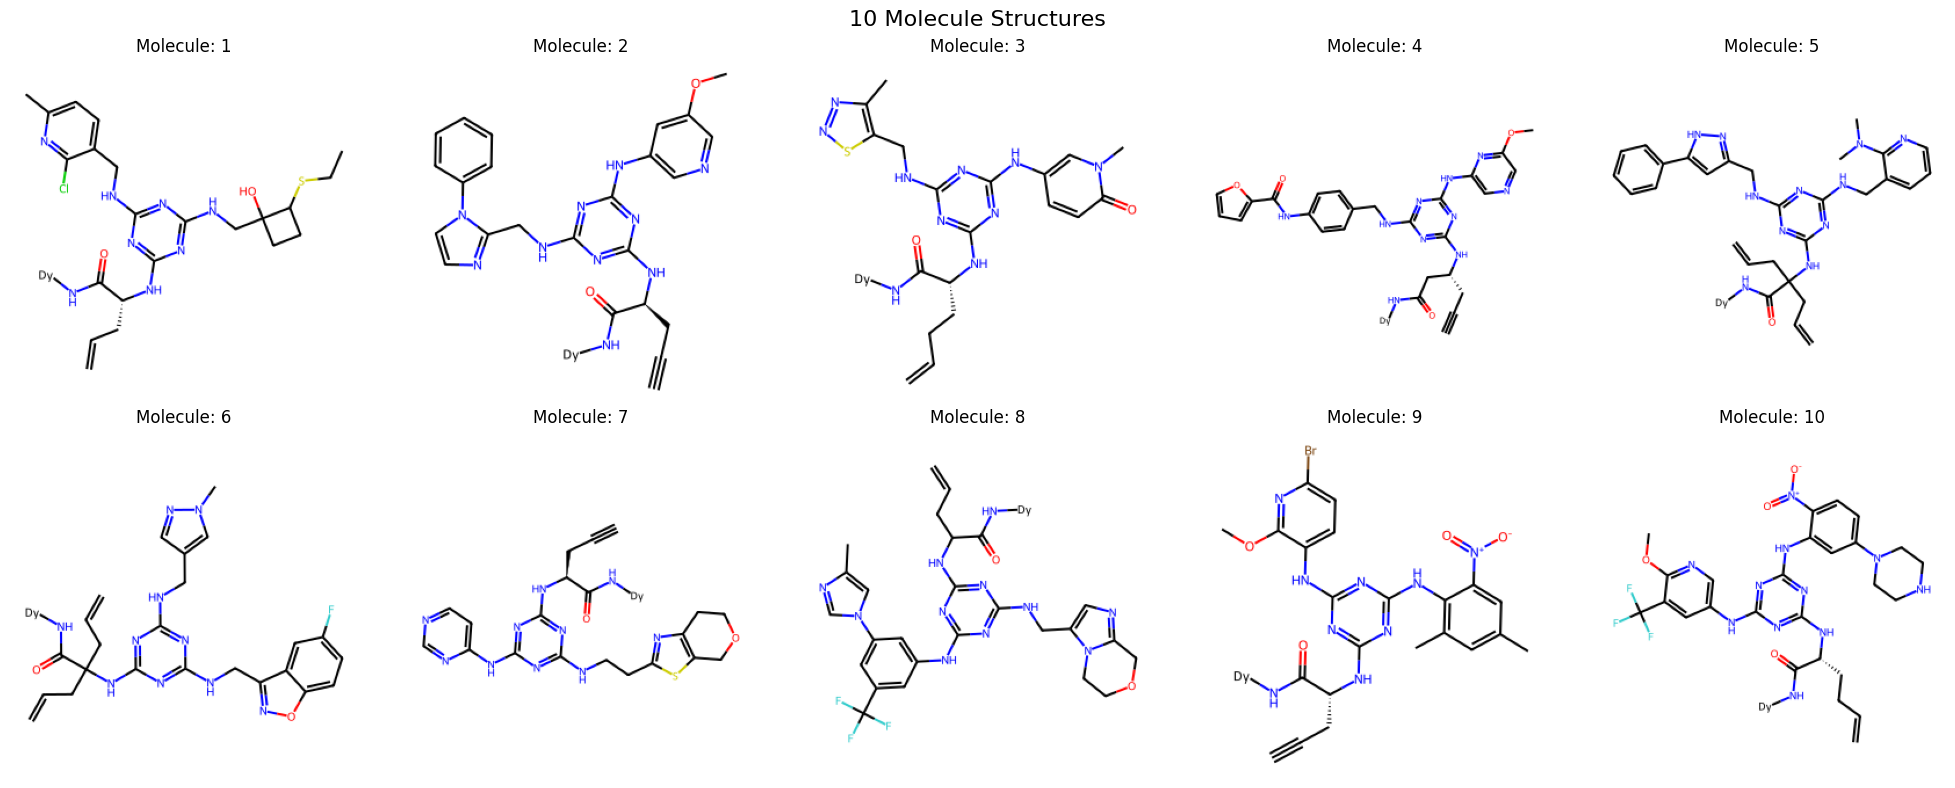

In [50]:
#@title Plotting Some Joint Molecules

fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns
fig.suptitle("10 Molecule Structures", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Draw each molecule
for i, mol in enumerate(mols[:10]):  # Limit to first 10 molecules
    img = Draw.MolToImage(mol)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Molecule: {i+1}")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [51]:
#@title Creating Joint Molecule Feature DF with RDKit Descriptors

def generate_descriptors(mols):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

    mol_descriptors = []
    for mol in mols:
        rdkit_descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(rdkit_descriptors)

    desc_names = calc.GetDescriptorNames()
    return pd.DataFrame(mol_descriptors, columns=desc_names)

descriptor_df = generate_descriptors(mols)
descriptor_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.265342,-0.817331,12.265342,0.178329,0.160236,668.556,638.316,669.119271,193,0,...,1,0,0,0,0,0,0,0,0,0
1,12.279322,-0.735125,12.279322,0.139598,0.179336,646.016,622.832,647.129720,191,0,...,0,0,0,1,0,0,0,0,0,0
2,12.308944,-0.561030,12.308944,0.134840,0.232537,618.028,594.844,619.101791,177,0,...,0,0,0,0,0,0,0,0,0,0
3,12.194836,-0.417784,12.194836,0.120114,0.128735,704.052,678.852,705.135199,213,0,...,0,0,0,1,0,0,0,0,0,0
4,13.028187,-1.087932,13.028187,0.212953,0.115166,715.167,680.895,716.223955,221,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19656,12.154962,-0.737340,12.154962,0.065949,0.210646,603.379,584.227,604.075432,169,0,...,0,0,0,1,0,0,0,0,0,0
19657,12.158714,-2.548818,12.158714,0.018345,0.114201,619.962,592.746,621.141508,187,0,...,0,0,0,1,0,0,0,0,4,0
19658,12.130579,-0.759683,12.130579,0.020352,0.148067,618.003,590.787,619.155935,185,0,...,0,0,0,1,0,0,0,0,1,1
19659,12.353414,-0.589706,12.353414,0.206257,0.189603,648.032,622.832,649.145370,193,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
smiles_to_descriptors = dict(zip(smiles, descriptor_df.to_dict('records')))

def add_molecule_features(row):
    mol_features = smiles_to_descriptors[row['molecule_smiles']]
    for key, value in mol_features.items():
        row[f'mol_{key}'] = value
    return row

df = df.apply(add_molecule_features, axis=1)
df.head()

In [ ]:
print(df.info())

In [ ]:
def get_atoms_and_positions(mols):
    results = []
    for mol in mols:
        if mol is not None:
            # Add hydrogens to the molecule
            mol = Chem.AddHs(mol)

            # Generate a 3D conformation
            AllChem.EmbedMolecule(mol, randomSeed=42)

            # Optimize the structure
            AllChem.MMFFOptimizeMolecule(mol)

            # Get atom symbols and positions
            conf = mol.GetConformer()
            atoms_and_positions = [
                (atom.GetSymbol(), conf.GetAtomPosition(atom.GetIdx()))
                for atom in mol.GetAtoms()
            ]
            results.append(atoms_and_positions)
        else:
            results.append(None)

    return results

# Example usage:
# Assuming you have your SMILES in a list or Series called 'smiles'
# smiles = ["CC(=O)OC1=CC=CC=C1C(=O)O", "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", ...]
# mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

atoms_and_positions_list = get_atoms_and_positions(mols[:1])

# Print results for the first molecule (if available)
if atoms_and_positions_list and atoms_and_positions_list[0]:
    print("Atoms and positions for the first molecule:")
    for atom, position in atoms_and_positions_list[0]:
        print(f"{atom}: ({position.x:.3f}, {position.y:.3f}, {position.z:.3f})")

In [ ]:
def get_detailed_atom_features(mols):
    results = []
    for mol in mols:
        if mol is not None:
            # Add hydrogens to the molecule
            mol = Chem.AddHs(mol)

            # Try to generate a 3D conformation
            try:
                AllChem.EmbedMolecule(mol, randomSeed=42)
                AllChem.MMFFOptimizeMolecule(mol)
            except:
                print("MMFF94 failed, trying UFF...")
                AllChem.EmbedMolecule(mol, randomSeed=42)
                AllChem.UFFOptimizeMolecule(mol, maxIters=200)

            # Compute Gasteiger charges
            ComputeGasteigerCharges(mol)

            # Get atom features
            conf = mol.GetConformer()
            atom_features = []
            for atom in mol.GetAtoms():
                position = conf.GetAtomPosition(atom.GetIdx())
                if position.x != 0 or position.y != 0 or position.z != 0:
                    features = {
                        'symbol': atom.GetSymbol(),
                        'position': (position.x, position.y, position.z),
                        'atomic_number': atom.GetAtomicNum(),
                        'degree': atom.GetDegree(),
                        'formal_charge': atom.GetFormalCharge(),
                        'hybridization': str(atom.GetHybridization()),
                        'is_aromatic': atom.GetIsAromatic(),
                        'is_in_ring': atom.IsInRing(),
                        'total_num_Hs': atom.GetTotalNumHs(),
                        'gasteiger_charge': atom.GetDoubleProp('_GasteigerCharge'),
                        'mass': atom.GetMass(),
                        'valence': atom.GetTotalValence(),
                        'implicit_valence': atom.GetImplicitValence(),
                        'explicit_valence': atom.GetExplicitValence(),
                        'chirality': str(atom.GetChiralTag())
                    }
                    atom_features.append(features)
                else:
                    print(f"Warning: Atom {atom.GetSymbol()} (index {atom.GetIdx()}) has coordinates (0,0,0). It may not have been placed correctly.")

            results.append(atom_features)
        else:
            results.append(None)

    return results

# Example usage:
# Assuming you have your SMILES in a list or Series called 'smiles'
# smiles = ["CC(=O)OC1=CC=CC=C1C(=O)O", "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", ...]
# mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

detailed_atom_features = get_detailed_atom_features(mols[:1])

# Print results for the first atom of the first molecule (if available)
if detailed_atom_features and detailed_atom_features[0]:
    print("Detailed features for the first atom of the first molecule:")
    for key, value in detailed_atom_features[0][0].items():
        print(f"{key}: {value}")
else:
    print("No data available for the first molecule")

In [ ]:
def detailed_ss_prediction(phi, psi):
    if phi is None or psi is None:
        return '-'
    phi, psi = np.degrees(phi), np.degrees(psi)
    if -70 <= phi <= -30 and -70 <= psi <= -30:
        return 'H'  # Alpha helix
    elif -80 <= phi <= -20 and 120 <= psi <= 180:
        return 'G'  # 3-10 helix
    elif -180 <= phi <= -45 and 90 <= psi <= 180:
        return 'E'  # Extended strand
    elif -180 <= phi <= -45 and -50 <= psi <= 50:
        return 'B'  # Isolated beta-bridge
    elif -90 <= phi <= 0 and 0 <= psi <= 120:
        return 'T'  # Turn
    elif (phi <= -100 and 120 <= psi <= 180) or (phi >= 100 and 120 <= psi <= 180):
        return 'S'  # Bend
    else:
        return 'C'  # Coil

def calculate_exposure(residue):
    if "CA" not in residue:
        return None
    ca_atom = residue["CA"]
    center = ca_atom.coord
    neighbor_count = sum(1 for atom in residue.get_parent().get_atoms()
                         if atom.name == "CA" and np.linalg.norm(atom.coord - center) < 10)
    return neighbor_count

def extract_alphafold_features(pdb_file):
    parser = PDBParser()
    structure = parser.get_structure("protein", pdb_file)
    model = structure[0]

    features = {}
    ss_counts = {'-': 0, 'H': 0, 'G': 0, 'E': 0, 'B': 0, 'T': 0, 'S': 0, 'C': 0}
    exposure_scores = []
    plddt_scores = []

    # Assign detailed secondary structure
    ppb = PPBuilder()
    total_residues = 0
    for pp in ppb.build_peptides(structure):
        phi_psi = pp.get_phi_psi_list()
        for i, residue in enumerate(pp):
            total_residues += 1
            phi, psi = phi_psi[i]
            ss = detailed_ss_prediction(phi, psi)
            ss_counts[ss] += 1

            if "CA" in residue:
                plddt_scores.append(residue["CA"].get_bfactor())

            exposure = calculate_exposure(residue)
            if exposure is not None:
                exposure_scores.append(exposure)

    # Calculate secondary structure composition
    for ss, count in ss_counts.items():
        features[f"ss_{ss}"] = (count / total_residues) * 100

    # Calculate exposure and pLDDT statistics
    features['max_exposure'] = max(exposure_scores) if exposure_scores else np.nan
    features['min_exposure'] = min(exposure_scores) if exposure_scores else np.nan
    features['mean_exposure'] = np.mean(exposure_scores) if exposure_scores else np.nan
    features['max_plddt'] = max(plddt_scores) if plddt_scores else np.nan
    features['min_plddt'] = min(plddt_scores) if plddt_scores else np.nan
    features['mean_plddt'] = np.mean(plddt_scores) if plddt_scores else np.nan

    return features

# Usage
protein_files = {
    'sEH': "AF-P34913-F1-model_v4.pdb",
    'BRD4': "AF-O60885-F1-model_v4.pdb",
    'HSA': "AF-P02768-F1-model_v4.pdb"
}

protein_features = {name: extract_alphafold_features(file) for name, file in protein_files.items()}

# Print secondary structure composition for each protein
for protein, features in protein_features.items():
    print(f"\nSecondary Structure Composition of {protein}:")
    for ss in ['-', 'H', 'G', 'E', 'B', 'T', 'S', 'C']:
        print(f"{ss}: {features[f'ss_{ss}']:.2f}%")
    print(f"Max Exposure: {features['max_exposure']}")
    print(f"Min Exposure: {features['min_exposure']}")
    print(f"Mean Exposure: {features['mean_exposure']:.2f}")
    print(f"Max pLDDT: {features['max_plddt']}")
    print(f"Min pLDDT: {features['min_plddt']}")
    print(f"Mean pLDDT: {features['mean_plddt']:.2f}")

# Add protein features to the dataframe
for feature in protein_features['sEH'].keys():
    df[feature] = df['protein_name'].map(lambda x: protein_features[x][feature])

In [ ]:
# Display the first few rows of the updated dataframe
df.head()

In [ ]:
# Check for any remaining NaN values
print(df.isna().sum())

In [ ]:
# # Usage
# sEH_features = extract_alphafold_features("/AF-P34913-F1-model_v4.pdb")
# BRD4_features = extract_alphafold_features("/AF-O60885-F1-model_v4.pdb")
# HSA_features = extract_alphafold_features("/AF-P02768-F1-model_v4.pdb")

# # Print a few features as an example
# # for key in list(ephx2_features.keys())[0:]:
# #     print(f"{key}: {ephx2_features[key]}")
# # for key in list(brd4_features.keys())[0:]:
# #     print(f"{key}: {brd4_features[key]}")
# # for key in list(alb_features.keys())[0:]:
# #     print(f"{key}: {alb_features[key]}")


# # Calculate and print secondary structure composition
# ss_composition_sEH = {}
# for value in sEH_features.values():
#     if isinstance(value, str) and len(value) == 1:
#         ss_composition_sEH[value] = ss_composition_sEH.get(value, 0) + 1

# total = sum(ss_composition_sEH.values())
# print("\nSecondary Structure Composition of sEH:")
# for ss, count in ss_composition_sEH.items():
#     percentage = (count / total) * 100
#     print(f"{ss}: {percentage:.2f}%")

# ss_composition_BRD4 = {}
# for value in BRD4_features.values():
#     if isinstance(value, str) and len(value) == 1:
#         ss_composition_BRD4[value] = ss_composition_BRD4.get(value, 0) + 1

# total = sum(ss_composition_BRD4.values())
# print("\nSecondary Structure Composition of BRD4:")
# for ss, count in ss_composition_BRD4.items():
#     percentage = (count / total) * 100
#     print(f"{ss}: {percentage:.2f}%")

# ss_composition_HSA = {}
# for value in HSA_features.values():
#     if isinstance(value, str) and len(value) == 1:
#         ss_composition_HSA[value] = ss_composition_HSA.get(value, 0) + 1

# total = sum(ss_composition_HSA.values())
# print("\nSecondary Structure Composition of HSA:")
# for ss, count in ss_composition_HSA.items():
#     percentage = (count / total) * 100
#     print(f"{ss}: {percentage:.2f}%")

In [ ]:
# # We create a dictionary to store all our protein data
# protein_data = {
#     'sEH': sEH_features,
#     'BRD4': BRD4_features,
#     'HSA': HSA_features
# }

# # Function to extract exposure scores
# def extract_exposure_scores(features):
#     return {int(key.split('_')[1]): value for key, value in features.items() if key.endswith('_exposure')}

# # Function to calculate secondary structure composition
# def calculate_ss_composition(features):
#     ss_composition = {}
#     for value in features.values():
#         if isinstance(value, str) and len(value) == 1:
#             ss_composition[value] = ss_composition.get(value, 0) + 1
#     total = sum(ss_composition.values())
#     return {ss: (count / total) * 100 for ss, count in ss_composition.items()}

# # Function to calculate exposure score statistics
# def calculate_exposure_stats(exposure_scores):
#     scores = list(exposure_scores.values())
#     return {
#         'mean': statistics.mean(scores),
#         'median': statistics.median(scores),
#         'max': max(scores),
#         'min': min(scores)
#     }

# # Process each protein
# for protein_name, features in protein_data.items():
#     # Extract exposure scores
#     exposure_scores = extract_exposure_scores(features)

#     # Calculate secondary structure composition
#     ss_composition = calculate_ss_composition(features)

#     # Calculate exposure score statistics
#     exposure_stats = calculate_exposure_stats(exposure_scores)

#     # Store processed data back in the dictionary
#     protein_data[protein_name] = {
#         'features': features,
#         'exposure_scores': exposure_scores,
#         'ss_composition': ss_composition,
#         'exposure_stats': exposure_stats
#     }

# # Now you can easily access the data for each protein
# for protein_name, data in protein_data.items():
#     print(f"\n{protein_name}:")
#     print("Secondary Structure Composition:")
#     for ss, percentage in data['ss_composition'].items():
#         print(f"{ss}: {percentage:.2f}%")

#     print("\nExposure Score Statistics:")
#     for stat, value in data['exposure_stats'].items():
#         print(f"{stat.capitalize()}: {value:.2f}")

#     print("\nExposure Scores (first 5):")
#     for residue, score in list(data['exposure_scores'].items())[:5]:
#         print(f"Residue {residue}: {score}")

# # If you want to access the original features, you can do:
# # ephx2_features = protein_data['EPHX2']['features']
# # And so on for other proteins

# Data Analysis and Adjustments

In [ ]:
# List of columns to drop
columns_to_drop = ['id', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles', 'molecule_smiles', 'protein_name']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

In [ ]:
# Display the first few rows and info of the modified dataframe with only numerical inputs
df.head()

In [ ]:
#@title Explore Data

print(f'{df.shape}\n, {df.info()}\n, {df.describe().T}')

In [ ]:
# Identify zero-variance features
zero_var_features = df.columns[df.var() == 0]

print("Features with zero variance:", zero_var_features)

# Remove zero-variance features for plotting
df_plot = df.drop(columns=zero_var_features)

In [ ]:
f = pd.melt(frame=df_plot)
g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, 'value', kde=True)

In [ ]:
print(df_plot['binds'].value_counts(), df_plot['ss_C'].value_counts())

In [ ]:
# Remove columns with infinity values
df_cleaned = df_plot.select_dtypes(exclude=['object']).replace([np.inf, -np.inf], np.nan).dropna(axis=1)

removed_columns = set(df_plot.columns) - set(df_cleaned.columns)
print("Columns removed due to infinity values:", removed_columns)

In [ ]:
f = pd.melt(frame=df_cleaned)
g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, 'value', kde=True)

# First Round of Simple Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statistics import mean

In [ ]:
X = df_cleaned.drop('binds', axis=1)
y = df_cleaned['binds']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Custom Dataset
class BindingDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels).unsqueeze(1)  # Ensure labels are 2D

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoaders
train_dataset = BindingDataset(X_train_scaled, y_train.values)
val_dataset = BindingDataset(X_val_scaled, y_val.values)
test_dataset = BindingDataset(X_test_scaled, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

def get_accuracy(outputs, y):
    predicted = (outputs > 0.5).float()
    return (predicted == y).float().mean().item()

def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    losses = []
    accuracies = []

    for data, target in dataloader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)

        output = model(data)

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(get_accuracy(output, target))

    return mean(losses), mean(accuracies)



def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    losses = []
    accuracies = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            loss = loss_fn(output, target)

            losses.append(loss.item())
            accuracies.append(get_accuracy(output, target))

    return mean(losses), mean(accuracies)

def train_model(model, train_loader, val_loader, test_loader, epochs=40, device='cuda'):
    model.to(device)
    loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    best_val_accuracy = -1

    for epoch in range(epochs):
        train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn, device)
        test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            msg = "New best model saved!"
        else:
            msg = ""

        print(
            f"Epoch {epoch+1:02d}: train loss {train_loss:.4f} train acc {train_accuracy:.4f} "
            f"val loss {val_loss:.4f} val acc {val_accuracy:.4f} "
            f"test loss {test_loss:.4f} test acc {test_accuracy:.4f} {msg}"
        )

def count_parameters(model):
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The number of trainable parameters.

    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train.shape[1]  # number of features
model = MLP(input_size=input_size, hidden_size=128, output_size=1)
print(f"The model has {count_parameters(model):,} trainable parameters")

# Train the model
train_model(model, train_loader, val_loader, test_loader, epochs=50, device=device)

# Make predictions
model.eval()
with torch.no_grad():
    new_data = torch.randn(5, input_size).to(device)
    predictions = model(new_data)
    print("Predictions:", predictions)
    binary_predictions = (predictions > 0.5).float()
    print("Binary Predictions:", binary_predictions)

# Results:

Size of Dataset = 2,000: Epoch 15: train loss 0.0409 train acc 0.9910 val loss 1.3169 val acc 0.8005 test loss 1.0893 test acc 0.7596 New best model saved!


Size of Dataset = 20,000: Epoch 17: train loss 0.1009 train acc 0.9630 val loss 0.5201 val acc 0.8622 test loss 0.5399 test acc 0.8488 New best model saved!

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Combine training and validation sets for GridSearchCV
X_train_full = np.vstack((X_train_scaled, X_val_scaled))
y_train_full = np.concatenate((y_train, y_val))

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Now you can proceed with your SVM
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)

# Evaluate
y_pred = svm.predict(X_test_scaled)
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Results:

Size of Dataset = 2,000:

Classification Report:

                precision    recall  f1-score   support

           0       0.74      0.75      0.75       203
           1       0.74      0.73      0.74       197

    accuracy                           0.74       400
    macro avg      0.74      0.74      0.74       400
    weighted avg   0.74      0.74      0.74       400

Size of Dataset = 20,000:

Classification Report:

                precision    recall  f1-score   support

           0       0.84      0.87      0.86      1945
           1       0.88      0.84      0.86      2055

    accuracy                           0.86      4000
    macro avg        0.86      0.86    0.86      4000
    weighted avg     0.86      0.86    0.86      4000

In [ ]:
# Feature selection
selector = SelectKBest(f_classif, k='all')  # Start with all features, we'll analyze importance later
X_train_selected = selector.fit_transform(X_train_full, y_train_full)
X_test_selected = selector.transform(X_test_scaled)

# Handle potential class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train_full)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None]
}

# Create SVM model
svm = SVC(random_state=42, probability=True)

# Set up GridSearchCV with stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_svm = grid_search.best_estimator_

# Make predictions
y_pred = best_svm.predict(X_test_selected)
y_prob = best_svm.predict_proba(X_test_selected)[:, 1]

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance analysis
feature_importance = selector.scores_
feature_indices = np.argsort(feature_importance)[::-1]
importance_df = pd.DataFrame({
    'feature': [f'feature_{i}' for i in feature_indices],
    'importance': feature_importance[feature_indices]
})
print("\nTop 10 Important Features:")
print(importance_df.head(10))

# Optionally, retrain with top features
top_k_features = 10  # or however many you want
selector = SelectKBest(f_classif, k=top_k_features)
X_train_top = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_top = selector.transform(X_test_selected)

best_svm.fit(X_train_top, y_train_resampled)
y_pred_top = best_svm.predict(X_test_top)

print("\nClassification Report with Top Features:")
print(classification_report(y_test, y_pred_top))

# Example of using the model for prediction
new_data = np.random.randn(5, X_test_scaled.shape[1])  # 5 new samples
new_data_selected = selector.transform(new_data)
predictions = best_svm.predict(new_data_selected)
probabilities = best_svm.predict_proba(new_data_selected)[:, 1]

print("\nPredictions for new data:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Sample {i+1}: Prediction = {pred}, Probability = {prob:.4f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits


# Results:

Size of Dataset = 2,000:

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

Best cross-validation score: 0.8011920723404271

Classification Report:

                precision    recall  f1-score   support

           0       0.77      0.82      0.79       203
           1       0.80      0.75      0.77       197

    accuracy                           0.78       400
    macro avg      0.78      0.78      0.78       400
    weighted avg   0.78      0.78      0.78       400



In [ ]:
# Use PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Train SVM on reduced data
svm = SVC(kernel='rbf')
svm.fit(X_pca, y_train)

# Create a mesh to plot in
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict the function value for the whole grid
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolor='black')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('SVM Decision Boundary (PCA-reduced to 2D)')
plt.show()

In [ ]:
# Train SVM
svm = SVC(probability=True)  # We need probability estimates
svm.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_proba = svm.predict_proba(X_test_scaled)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Train SVM
svm = SVC()
svm.fit(X_train_scaled, y_train)

# Predict
y_pred = svm.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Second Round of Models:

In [ ]:
#@title We Add in L1 and L2 Regularisation Into Our Vanilla MLP to Reduce the Overfitting

class RegularizedMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

def tune_hyperparameters(input_size, hidden_size, output_size, train_loader, val_loader, device):
    learning_rates = [0.1, 0.01, 0.001]
    weight_decays = [0.0, 1e-4, 1e-3]
    dropout_rates = [0.3, 0.5]

    best_val_accuracy = -1
    best_params = {}

    for lr in learning_rates:
        for wd in weight_decays:
            for dr in dropout_rates:
                print(f"\nTrying lr={lr}, weight_decay={wd}, dropout_rate={dr}")
                model = RegularizedMLP(input_size, hidden_size, output_size, dropout_rate=dr).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

                # Train for a few epochs
                for epoch in range(10):
                    train_epoch(model, train_loader, nn.BCELoss(), optimizer, device)
                    val_loss, val_accuracy = evaluate_model(model, val_loader, nn.BCELoss(), device)
                    scheduler.step(val_accuracy)

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_params = {'lr': lr, 'weight_decay': wd, 'dropout_rate': dr}

    print(f"\nBest parameters: {best_params}")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")

    return best_params

# Assuming you have already defined train_epoch, evaluate_model, and train_model functions

# Main execution
if __name__ == "__main__":
    # Load your data and create data loaders (train_loader, val_loader, test_loader)
    # ...

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get input size from your data
    input_size = X_train.shape[1]  # number of features
    hidden_size = 128
    output_size = 1

    # Perform hyperparameter tuning
    best_params = tune_hyperparameters(input_size, hidden_size, output_size, train_loader, val_loader, device)

    # Initialize the model with best parameters
    model = RegularizedMLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                           dropout_rate=best_params['dropout_rate']).to(device)
    print(f"The model has {count_parameters(model):,} trainable parameters")

    # Train the model
    train_model(model, train_loader, val_loader, test_loader, epochs=50,
                lr=best_params['lr'], weight_decay=best_params['weight_decay'], device=device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        new_data = torch.randn(5, input_size).to(device)
        predictions = model(new_data)
        print("Predictions:", predictions)
        binary_predictions = (predictions > 0.5).float()
        print("Binary Predictions:", binary_predictions)

# Results:

Size of Dataset = 2000: Epoch 50: train loss 0.0849 train acc 0.9696 val loss 1.0417 val acc 0.7933 test loss 0.8263 test acc 0.7764 No improvement for 16 epochs